### mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/JnQ/'

os.chdir(current_path)

Mounted at /content/drive


### requirements

In [3]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from funcs_indicator import *
# import matplotlib.pyplot as plt

# import mpl_finance as mf
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### load data

In [4]:
os.chdir(current_path)


interval = '30m'
interval = '5m'
interval = '1m'

date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
# date_path = './candlestick_concated/%s/2021-06-14/' % interval
date_path = './candlestick_concated/%s/eth_set/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 ETHUSDT.xlsx', '2021-04-17 ETHUSDT.xlsx', '2021-03-18 ETHUSDT.xlsx', '2021-02-16 ETHUSDT.xlsx', '2021-01-17 ETHUSDT.xlsx', '2020-12-18 ETHUSDT.xlsx', '2020-11-18 ETHUSDT.xlsx', '2020-10-19 ETHUSDT.xlsx', '2020-09-19 ETHUSDT.xlsx', '2020-08-20 ETHUSDT.xlsx', '2020-07-21 ETHUSDT.xlsx', '2020-06-21 ETHUSDT.xlsx', '2020-05-22 ETHUSDT.xlsx', '2020-04-22 ETHUSDT.xlsx']


### windowing + retrain

#### window settings

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

window_size = 30
input_size = 15
# label_size = 15
label_size = 1

target = "pr"

start_stamp : 0


#### make datasets

In [6]:
data_x, data_labels = [], []
data_x_labels = []

fee = 0.0006

# close_x, label_close_x = [], []
# data_index = []

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  # if 'neo'.upper() not in candis[i]:
    # continue
  
  # if 'btc'.upper() not in candis[i]:
  #   continue

  if 'eth'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))
    df = ohlcv

    # df['pr'] = df['close'].pct_change()

    #   진입 구간과 이탈 구간에서 발생하는 pr 만들기    #

    # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close']

    #         post fee adjustment       #
    # df['pr'] = df['close'].shift(-(label_size - 1)) / df['close'] - fee
    df['pr'] = df['close'].shift(-label_size) / df['close'] - fee

    # print(df['close'].head(20))
    # print(df['close'].shift(-14).head(20))
    # break

    # sar = lucid_sar(ohlcv)
    # ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
    # ema1, ema2, ema3 = ema_ribbon(ohlcv)
    # senkou1, senkou2 = ichimoku(ohlcv)
    # cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

    # _, _, bbw = bb_width(ohlcv, 20, 2) 

    df['fish60'] = fisher(ohlcv, 60)
    df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
    # rsi_ = rsi(ohlcv)
    df['macd_hist'] = macd(ohlcv)

    # print(df.describe().transpose())
    # print(df.head())

    # print((np.isnan(df.values)))
    print("np.sum(np.isnan(df.values), axis=0) :", np.sum(np.isnan(df.values), axis=0))

    max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
    # print(max_nan)

    df = df.iloc[max_nan:-max_nan]

    print("df.describe().transpose() :", df.describe().transpose())


    column_indices = {name: i for i, name in enumerate(df.columns)}
    num_features = df.shape[1]
    print("num_features :", num_features)
    print("column_indices :", column_indices)
    
    target_label_index = column_indices[target]

    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    min_max = MinMaxScaler()
    std_scale = StandardScaler()

    def min_max_scale(npy_x):

      return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


    #       local scaling     #
    # shift_size = window_size
    shift_size = label_size
    # shift_size = 1

    for i in range(input_size, len(df), shift_size):
        
        # temp_data = df.values[i - input_size:i]
        # temp_labels = df.values[i:i + label_size]

        # scaled_data = min_max_scale(df.values[i - input_size:i + label_size])
        # scaled_data = min_max.fit_transform(df.values[i - input_size:i + label_size])
        # temp_data = scaled_data[:input_size]
        # temp_labels = scaled_data[input_size:]

        #     ohlc    #
        temp_data = min_max_scale(df.values[i - input_size:i, :4])
        
        prev_data = df.values[i - input_size:i, :4]
        label_data = df.values[i: i + label_size, :4]
        temp_x_labels = (label_data - np.min(prev_data)) / (np.max(prev_data) - np.min(prev_data))

        temp_labels = df.values[i, target_label_index]

        # temp_data = std_scale.fit_transform(df.values[i - input_size:i])
        # # temp_labels = std_scale.transform(df.values[i:i + label_size])
        # temp_labels = df.values[i + shift - input_size:i + shift]

        # print(df.index[i - input_size:i][-1])
        # print(df.index[i:i + label_size][0])
        # print()

        if np.isnan(np.sum(temp_data)) or np.isnan(np.sum(temp_x_labels)):
          continue

        if len(temp_x_labels) < label_size:
          continue

        data_x.append(temp_data)
        data_x_labels.append(temp_x_labels)
        data_labels.append(temp_labels)
        # close_x.append(df.values[i - input_size:i, [3]])
        # label_close_x.append(df.values[i:i + label_size, [3]])


data_x = np.array(data_x).astype(np.float32)
data_x_labels = np.array(data_x_labels).astype(np.float32)
data_labels = np.array(data_labels).astype(np.float32)

# print(len(df) - total_window_size)
print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

print("data_x.dtype :", data_x.dtype)
print("data_labels.dtype :", data_labels.dtype)

len(ohlcv) : 43200
np.sum(np.isnan(df.values), axis=0) : [ 0  0  0  0  0  1 59  5 24]
df.describe().transpose() :              count         mean          std         min         25%         50%          75%           max
open       43082.0   152.694155    17.246243  123.830000  136.180000  154.400000   169.950000    189.160000
high       43082.0   152.812841    17.263469  124.020000  136.282500  154.500000   170.060000    189.680000
low        43082.0   152.563629    17.229060  123.740000  136.070000  154.260000   169.820000    189.000000
close      43082.0   152.691839    17.245724  123.800000  136.180000  154.395000   169.940000    189.150000
volume     43082.0  1166.819688  1934.881427    0.008000  309.094750  626.435000  1280.684500  59665.102000
pr         43082.0     0.999408     0.001287    0.980157    0.998817    0.999400     0.999996      1.016332
fish60     43082.0     0.160068     1.858830   -7.555023   -1.124660    0.156042     1.436256      7.600061
trix       43082.0    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in true_divide


len(ohlcv) : 43200
np.sum(np.isnan(df.values), axis=0) : [ 0  0  0  0  0  1 59  5 24]
df.describe().transpose() :              count          mean          std         min         25%         50%          75%           max
open       43082.0  3.862479e+02    30.549709  310.750000  366.932500  384.560000   399.380000    488.910000
high       43082.0  3.865795e+02    30.527124  314.560000  367.260000  384.835000   399.660000    489.320000
low        43082.0  3.859082e+02    30.571302  307.360000  366.640000  384.295000   399.100000    487.660000
close      43082.0  3.862472e+02    30.548698  310.580000  366.940000  384.560000   399.375000    488.910000
volume     43082.0  1.617769e+03  2466.757282   13.122000  456.958000  907.058000  1826.467250  76145.296000
pr         43082.0  9.993993e-01     0.001455    0.967210    0.998737    0.999374     1.000041      1.038002
fish60     43082.0  2.481830e-02     1.909176   -7.578176   -1.364584    0.041678     1.389920      7.591989
trix       430

#### save dataset

In [7]:
pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_prefee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

np.save(x_save_path, data_x)
np.save(x_label_save_path, data_x_labels)
np.save(label_save_path, data_labels)


#### load dataset

In [ ]:
key = "dates ETHUSDT.xlsx"
len_data_x = 20104

shift_size = 30

pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s_%s.npy' % (input_size, label_size, shift_size, pair_name, len_data_x)

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_postfee_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

# x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
# label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

data_x = np.load(x_save_path)
data_x_labels = np.load(x_label_save_path)
data_labels = np.load(label_save_path)

print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

data_x.shape : (20104, 15, 10)
data_x_labels.shape : (20104, 15, 10)
data_labels.shape : (20104,)


### single step models

In [8]:
MAX_EPOCHS = 100
# MAX_EPOCHS = 1000
# MAX_EPOCHS = 500

patience = MAX_EPOCHS // 5
# patience = 2

ckpt_path = current_path + 'ckpt/'

def compile_and_fit(model, model_name, train_flow, val_flow, class_weight=None, patience=patience):

  tf.keras.backend.clear_session()

  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

  # model.compile(loss='categorical_crossentropy', 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
  #               # optimizer=tf.optimizers.Adam(learning_rate=1e-6, decay=5e-7), 
  #               metrics=['accuracy'])
  
  # model.compile(loss='categorical_crossentropy', 
  # model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), 
  #               optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
  #               metrics=[tf.metrics.Accuracy()])

  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.optimizers.Adam(learning_rate=1e-4, decay=1e-5),
                optimizer=tf.optimizers.Adam(learning_rate=1e-5, decay=5e-6), 
                # optimizer=tf.optimizers.Adam(learning_rate=1e-3, decay=1e-4),
                metrics=[tf.metrics.MeanAbsoluteError()])
  

  history = model.fit(train_flow, epochs=MAX_EPOCHS,
                      validation_data=val_flow,
                      callbacks=[checkpoint, early_stopping],
                      # callbacks=[early_stopping],
                      # class_weight=class_weight
                      )
  return history

#### models

#### cnn 2d

In [9]:
# cnn2d_model = tf.keras.Sequential([
                                 
#       # Shape => [batch, 1, conv_units]
#       # tf.keras.layers.Input(shape=)
#       tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3),
#       tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3),
      
#       tf.keras.layers.Flatten(),
#       tf.keras.layers.Dense(128, activation='relu'),
#       tf.keras.layers.Dense(64, activation='relu'),

#       tf.keras.layers.Dense(2, activation="softmax")
# ])


def cnn2d_model(input_shape):

    visible = tf.keras.layers.Input(shape=input_shape, name='input')
    
    net = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)
    # net = tf.keras.layers.AveragePooling2D(padding='same')(net)


    # net = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = tf.keras.layers.BatchNormalization()(net)
    # net = tf.keras.layers.Activation('relu')(net)
    net = tf.keras.layers.LeakyReLU()(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2)(net)

    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    net = tf.keras.layers.Dense(64)(net)
    net = tf.keras.layers.LeakyReLU()(net)

    # net = tf.keras.layers.Dense(2, activation='softmax')(net)
    net = tf.keras.layers.Dense(1)(net)

    # create model 
    model = tf.keras.models.Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

##### lstm

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(1)
])


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    
    tf.keras.layers.Dense(units=1)
])


##### cnn

In [ ]:
CONV_WIDTH = 3

cnn_model = tf.keras.Sequential([
                                 
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
      # tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(3)),

      tf.keras.layers.Dense(64, activation='relu'),

      tf.keras.layers.Dense(1)
])

#### test_bed

last_index : 10000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 16s 11ms/step - loss: 0.0406 - mean_absolute_error: 0.1502 - val_loss: 0.0206 - val_mean_absolute_error: 0.1129

Epoch 00001: val_loss improved from inf to 0.02060, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_10000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_absolute_error: 0.0861 - val_loss: 0.0134 - val_mean_absolute_error: 0.0890

Epoch 00002: val_loss improved from 0.02060 to 0.01336, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_10000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0090 - mean_absolute_error: 0.0737 - val_loss: 0.0104 - val_mean_absolute_error: 0.0779

Ep

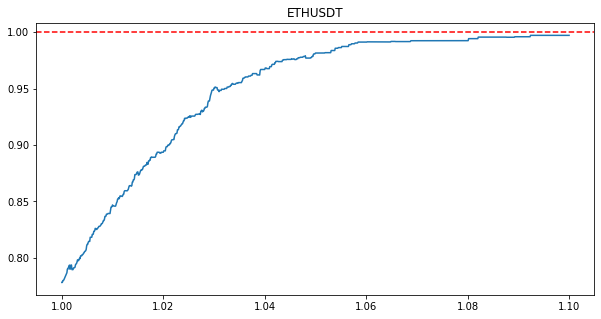

last_index : 11000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0903 - mean_absolute_error: 0.2104 - val_loss: 0.0235 - val_mean_absolute_error: 0.1207

Epoch 00001: val_loss improved from inf to 0.02351, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_11000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0140 - mean_absolute_error: 0.0927 - val_loss: 0.0153 - val_mean_absolute_error: 0.0956

Epoch 00002: val_loss improved from 0.02351 to 0.01525, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_11000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0108 - mean_absolute_error: 0.0813 - val_loss: 0.0123 - val_mean_absolute_error: 0.0851

Epoc

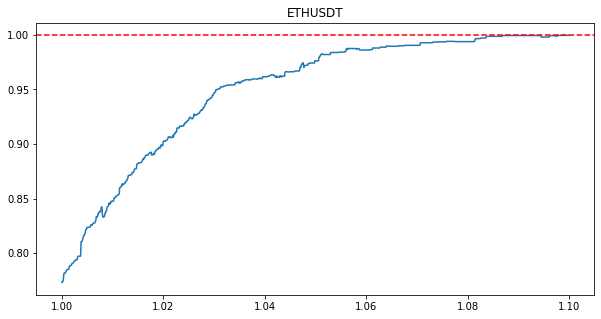

last_index : 12000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.0457 - mean_absolute_error: 0.1567 - val_loss: 0.0210 - val_mean_absolute_error: 0.1124

Epoch 00001: val_loss improved from inf to 0.02097, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_12000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0894 - val_loss: 0.0160 - val_mean_absolute_error: 0.0960

Epoch 00002: val_loss improved from 0.02097 to 0.01602, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_12000.h5
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_absolute_error: 0.0777 - val_loss: 0.0132 - val_mean_absolute_error: 0.0856

Epoc

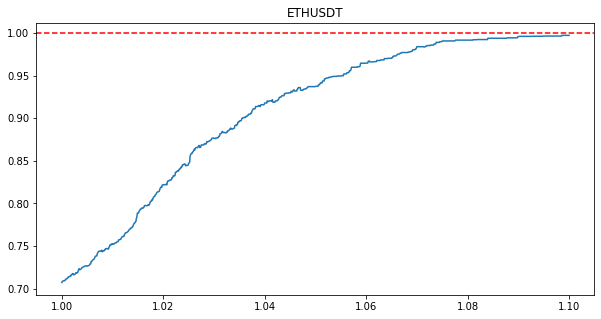

last_index : 13000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0824 - mean_absolute_error: 0.2039 - val_loss: 0.0202 - val_mean_absolute_error: 0.1120

Epoch 00001: val_loss improved from inf to 0.02017, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_13000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0171 - mean_absolute_error: 0.1018 - val_loss: 0.0150 - val_mean_absolute_error: 0.0939

Epoch 00002: val_loss improved from 0.02017 to 0.01499, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_13000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_absolute_error: 0.0865 - val_loss: 0.0121 - val_mean_absolute_error: 0.0844

Epoc

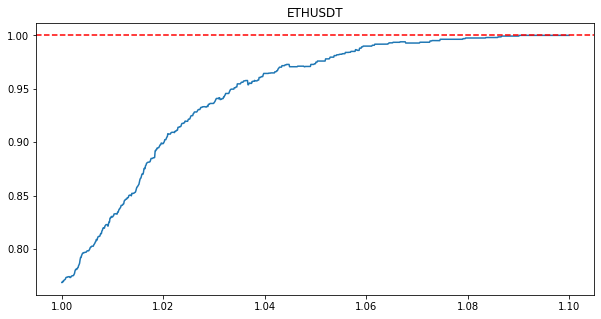

last_index : 14000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0669 - mean_absolute_error: 0.1923 - val_loss: 0.0167 - val_mean_absolute_error: 0.1008

Epoch 00001: val_loss improved from inf to 0.01671, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_14000.h5
Epoch 2/100
55/55 [==============================] - 0s 6ms/step - loss: 0.0162 - mean_absolute_error: 0.0988 - val_loss: 0.0118 - val_mean_absolute_error: 0.0852

Epoch 00002: val_loss improved from 0.01671 to 0.01175, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_14000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0827 - val_loss: 0.0095 - val_mean_absolute_error: 0.0765

Epoc

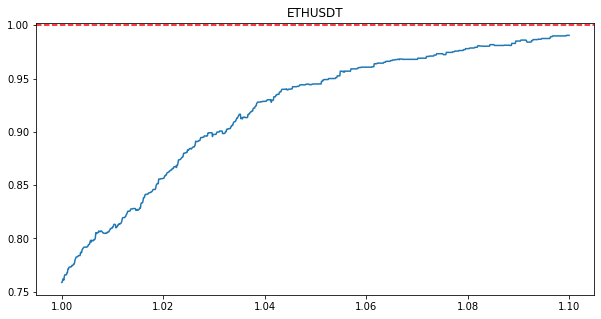

last_index : 15000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0703 - mean_absolute_error: 0.1896 - val_loss: 0.0202 - val_mean_absolute_error: 0.1121

Epoch 00001: val_loss improved from inf to 0.02023, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_15000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0169 - mean_absolute_error: 0.1008 - val_loss: 0.0132 - val_mean_absolute_error: 0.0905

Epoch 00002: val_loss improved from 0.02023 to 0.01316, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_15000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_absolute_error: 0.0865 - val_loss: 0.0109 - val_mean_absolute_error: 0.0818

Epoc

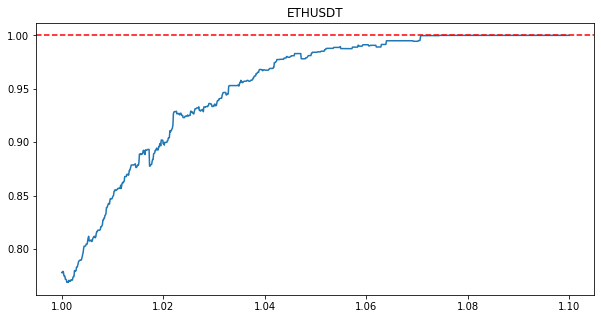

last_index : 16000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0431 - mean_absolute_error: 0.1534 - val_loss: 0.0164 - val_mean_absolute_error: 0.0986

Epoch 00001: val_loss improved from inf to 0.01636, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_16000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0131 - mean_absolute_error: 0.0873 - val_loss: 0.0119 - val_mean_absolute_error: 0.0833

Epoch 00002: val_loss improved from 0.01636 to 0.01194, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_16000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_absolute_error: 0.0749 - val_loss: 0.0094 - val_mean_absolute_error: 0.0740

Epoc

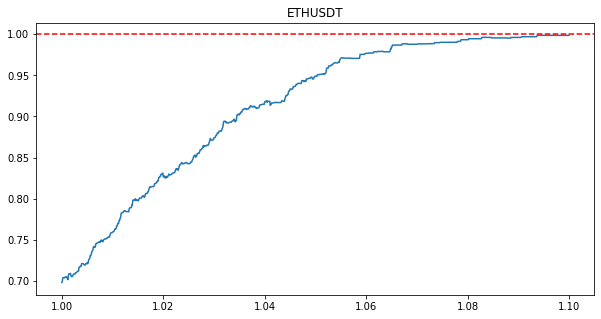

last_index : 17000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0615 - mean_absolute_error: 0.1850 - val_loss: 0.0162 - val_mean_absolute_error: 0.0991

Epoch 00001: val_loss improved from inf to 0.01620, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_17000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0156 - mean_absolute_error: 0.0973 - val_loss: 0.0109 - val_mean_absolute_error: 0.0799

Epoch 00002: val_loss improved from 0.01620 to 0.01094, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_17000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0115 - mean_absolute_error: 0.0824 - val_loss: 0.0091 - val_mean_absolute_error: 0.0728

Epoc

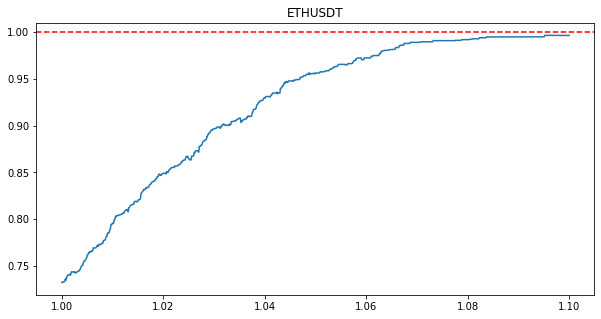

last_index : 18000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0340 - mean_absolute_error: 0.1401 - val_loss: 0.0145 - val_mean_absolute_error: 0.0947

Epoch 00001: val_loss improved from inf to 0.01446, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_18000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0132 - mean_absolute_error: 0.0889 - val_loss: 0.0113 - val_mean_absolute_error: 0.0824

Epoch 00002: val_loss improved from 0.01446 to 0.01131, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_18000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0101 - mean_absolute_error: 0.0774 - val_loss: 0.0086 - val_mean_absolute_error: 0.0729

Epo

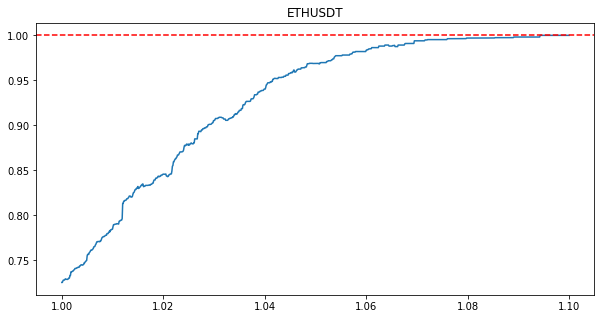

last_index : 19000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.1125 - mean_absolute_error: 0.2321 - val_loss: 0.0226 - val_mean_absolute_error: 0.1192

Epoch 00001: val_loss improved from inf to 0.02258, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_19000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0167 - mean_absolute_error: 0.1009 - val_loss: 0.0161 - val_mean_absolute_error: 0.1002

Epoch 00002: val_loss improved from 0.02258 to 0.01609, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_19000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_absolute_error: 0.0882 - val_loss: 0.0129 - val_mean_absolute_error: 0.0896

Epoc

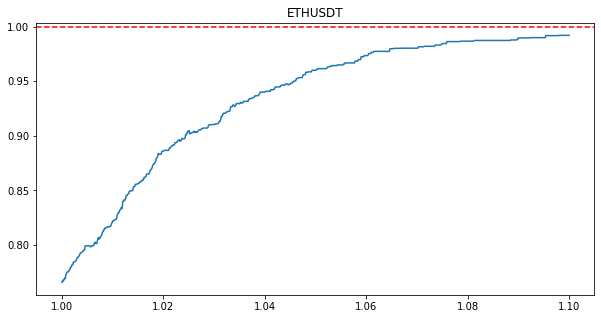

last_index : 20000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0341 - mean_absolute_error: 0.1364 - val_loss: 0.0146 - val_mean_absolute_error: 0.0954

Epoch 00001: val_loss improved from inf to 0.01465, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_20000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0106 - mean_absolute_error: 0.0801 - val_loss: 0.0114 - val_mean_absolute_error: 0.0826

Epoch 00002: val_loss improved from 0.01465 to 0.01137, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_20000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0719 - val_loss: 0.0091 - val_mean_absolute_error: 0.0752

Epo

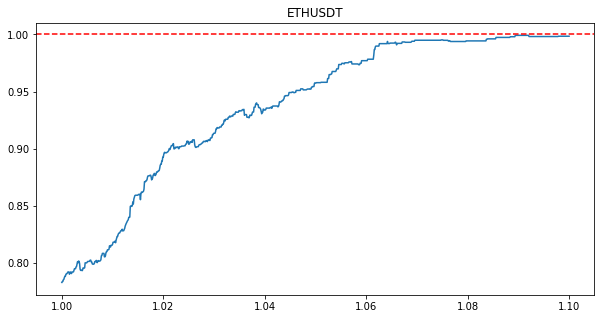

last_index : 21000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0781 - mean_absolute_error: 0.1990 - val_loss: 0.0216 - val_mean_absolute_error: 0.1182

Epoch 00001: val_loss improved from inf to 0.02162, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_21000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_absolute_error: 0.0981 - val_loss: 0.0161 - val_mean_absolute_error: 0.0997

Epoch 00002: val_loss improved from 0.02162 to 0.01609, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_21000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0121 - mean_absolute_error: 0.0849 - val_loss: 0.0132 - val_mean_absolute_error: 0.0900

Epoc

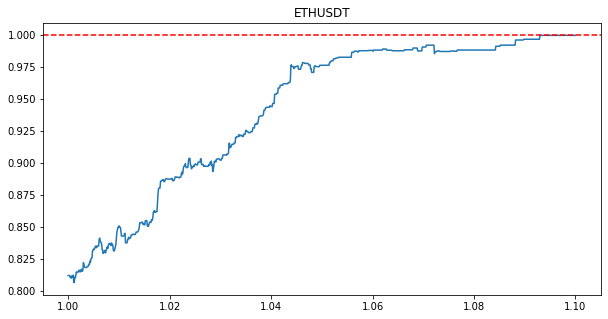

last_index : 22000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0372 - mean_absolute_error: 0.1409 - val_loss: 0.0134 - val_mean_absolute_error: 0.0877

Epoch 00001: val_loss improved from inf to 0.01341, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_22000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0803 - val_loss: 0.0103 - val_mean_absolute_error: 0.0776

Epoch 00002: val_loss improved from 0.01341 to 0.01026, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_22000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_absolute_error: 0.0718 - val_loss: 0.0084 - val_mean_absolute_error: 0.0687

Epo

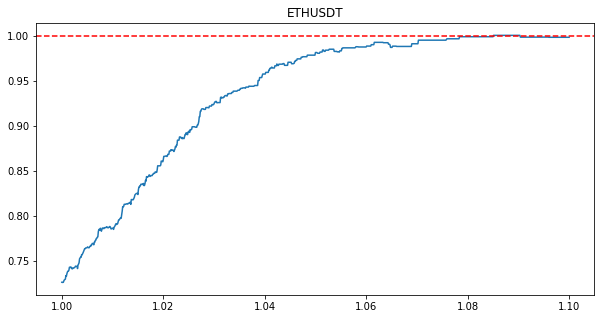

last_index : 23000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.1575 - mean_absolute_error: 0.2668 - val_loss: 0.0155 - val_mean_absolute_error: 0.0982

Epoch 00001: val_loss improved from inf to 0.01552, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_23000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0215 - mean_absolute_error: 0.1144 - val_loss: 0.0119 - val_mean_absolute_error: 0.0871

Epoch 00002: val_loss improved from 0.01552 to 0.01187, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_23000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0161 - mean_absolute_error: 0.0987 - val_loss: 0.0088 - val_mean_absolute_error: 0.0750

Epoc

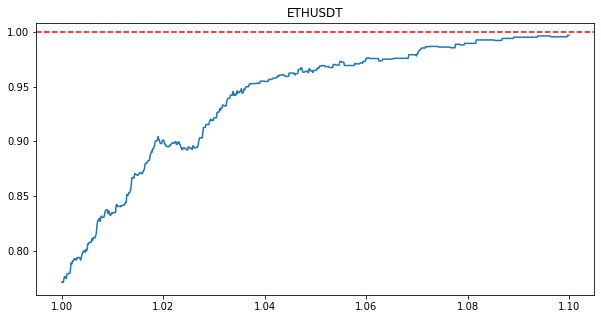

last_index : 24000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0666 - mean_absolute_error: 0.1867 - val_loss: 0.0136 - val_mean_absolute_error: 0.0930

Epoch 00001: val_loss improved from inf to 0.01356, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_24000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0155 - mean_absolute_error: 0.0962 - val_loss: 0.0086 - val_mean_absolute_error: 0.0737

Epoch 00002: val_loss improved from 0.01356 to 0.00863, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_24000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0114 - mean_absolute_error: 0.0817 - val_loss: 0.0072 - val_mean_absolute_error: 0.0671

Epo

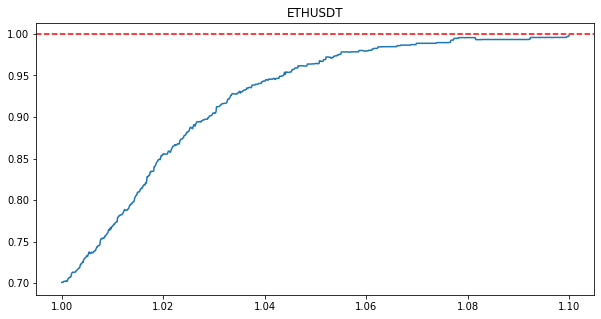

last_index : 25000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0217 - mean_absolute_error: 0.1128 - val_loss: 0.0093 - val_mean_absolute_error: 0.0768

Epoch 00001: val_loss improved from inf to 0.00926, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_25000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_absolute_error: 0.0778 - val_loss: 0.0070 - val_mean_absolute_error: 0.0666

Epoch 00002: val_loss improved from 0.00926 to 0.00698, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_25000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_absolute_error: 0.0689 - val_loss: 0.0058 - val_mean_absolute_error: 0.0603

Epoc

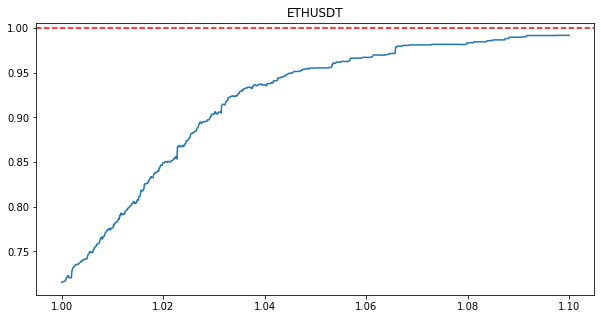

last_index : 26000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0993 - mean_absolute_error: 0.2255 - val_loss: 0.0183 - val_mean_absolute_error: 0.1065

Epoch 00001: val_loss improved from inf to 0.01829, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_26000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0192 - mean_absolute_error: 0.1085 - val_loss: 0.0120 - val_mean_absolute_error: 0.0876

Epoch 00002: val_loss improved from 0.01829 to 0.01201, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_26000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0143 - mean_absolute_error: 0.0936 - val_loss: 0.0090 - val_mean_absolute_error: 0.0756

Epo

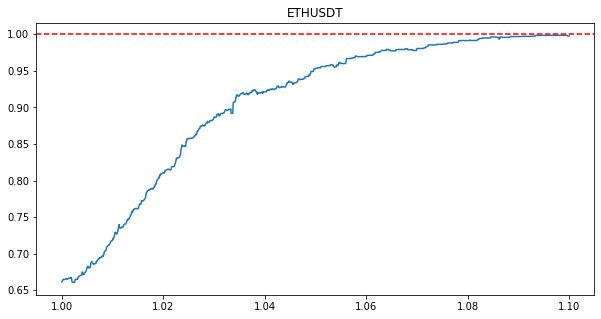

last_index : 27000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.1289 - mean_absolute_error: 0.2479 - val_loss: 0.0195 - val_mean_absolute_error: 0.1117

Epoch 00001: val_loss improved from inf to 0.01953, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_27000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0156 - mean_absolute_error: 0.0971 - val_loss: 0.0093 - val_mean_absolute_error: 0.0761

Epoch 00002: val_loss improved from 0.01953 to 0.00933, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_27000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0114 - mean_absolute_error: 0.0823 - val_loss: 0.0076 - val_mean_absolute_error: 0.0687

Epo

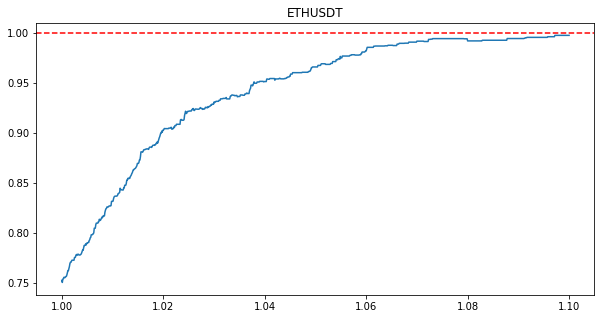

last_index : 28000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0647 - mean_absolute_error: 0.1865 - val_loss: 0.0155 - val_mean_absolute_error: 0.0989

Epoch 00001: val_loss improved from inf to 0.01550, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_28000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0139 - mean_absolute_error: 0.0929 - val_loss: 0.0101 - val_mean_absolute_error: 0.0791

Epoch 00002: val_loss improved from 0.01550 to 0.01014, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_28000.h5
Epoch 3/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0105 - mean_absolute_error: 0.0803 - val_loss: 0.0076 - val_mean_absolute_error: 0.0680

Ep

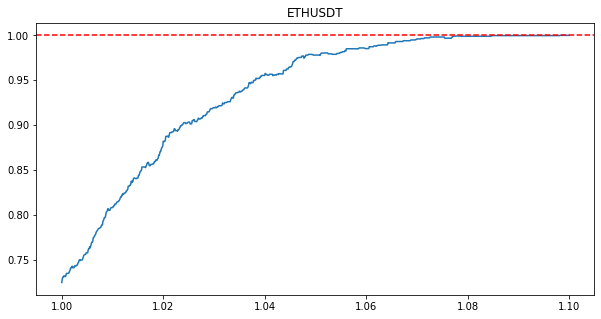

last_index : 29000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0766 - mean_absolute_error: 0.1909 - val_loss: 0.0149 - val_mean_absolute_error: 0.0975

Epoch 00001: val_loss improved from inf to 0.01493, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_29000.h5
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0135 - mean_absolute_error: 0.0910 - val_loss: 0.0108 - val_mean_absolute_error: 0.0805

Epoch 00002: val_loss improved from 0.01493 to 0.01078, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_29000.h5
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0103 - mean_absolute_error: 0.0793 - val_loss: 0.0082 - val_mean_absolute_error: 0.0703

Epo

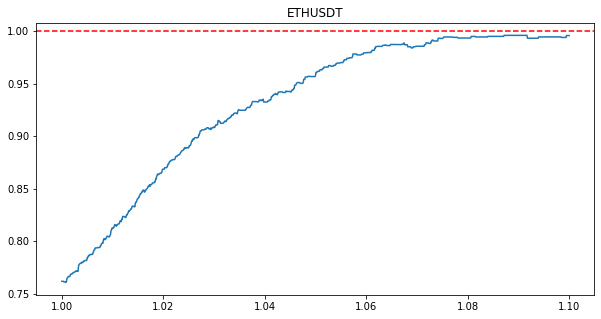

last_index : 30000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0555 - mean_absolute_error: 0.1708 - val_loss: 0.0156 - val_mean_absolute_error: 0.0977

Epoch 00001: val_loss improved from inf to 0.01565, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_30000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0112 - mean_absolute_error: 0.0832 - val_loss: 0.0108 - val_mean_absolute_error: 0.0800

Epoch 00002: val_loss improved from 0.01565 to 0.01079, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_30000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_absolute_error: 0.0694 - val_loss: 0.0085 - val_mean_absolute_error: 0.0703

Epo

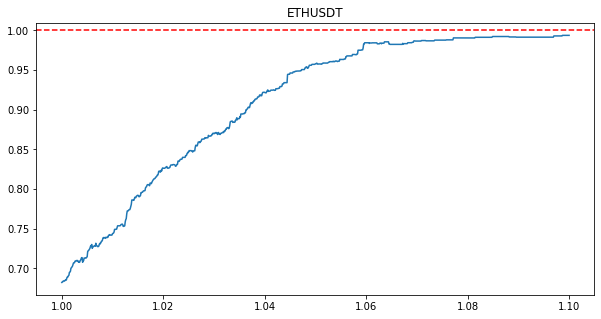

last_index : 31000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.1659 - mean_absolute_error: 0.2642 - val_loss: 0.0174 - val_mean_absolute_error: 0.1024

Epoch 00001: val_loss improved from inf to 0.01741, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_31000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_absolute_error: 0.0910 - val_loss: 0.0147 - val_mean_absolute_error: 0.0931

Epoch 00002: val_loss improved from 0.01741 to 0.01469, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_31000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0109 - mean_absolute_error: 0.0816 - val_loss: 0.0130 - val_mean_absolute_error: 0.0872

Epo

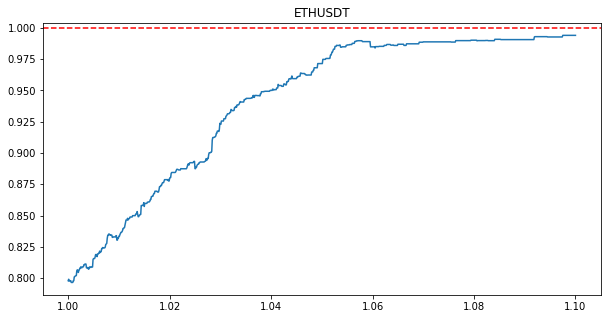

last_index : 32000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0683 - mean_absolute_error: 0.1901 - val_loss: 0.0199 - val_mean_absolute_error: 0.1103

Epoch 00001: val_loss improved from inf to 0.01995, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_32000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0131 - mean_absolute_error: 0.0895 - val_loss: 0.0139 - val_mean_absolute_error: 0.0911

Epoch 00002: val_loss improved from 0.01995 to 0.01392, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_32000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_absolute_error: 0.0771 - val_loss: 0.0114 - val_mean_absolute_error: 0.0819

Epo

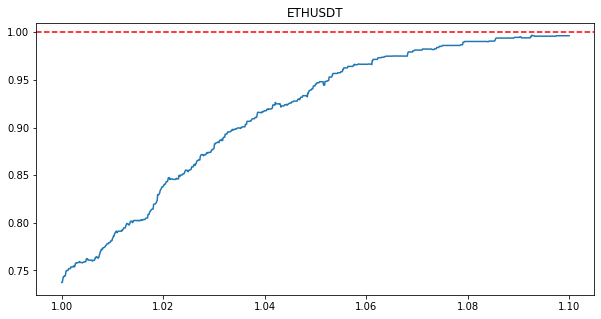

last_index : 33000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0197 - mean_absolute_error: 0.1080 - val_loss: 0.0127 - val_mean_absolute_error: 0.0876

Epoch 00001: val_loss improved from inf to 0.01272, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_33000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0085 - mean_absolute_error: 0.0715 - val_loss: 0.0090 - val_mean_absolute_error: 0.0728

Epoch 00002: val_loss improved from 0.01272 to 0.00900, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_33000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0613 - val_loss: 0.0073 - val_mean_absolute_error: 0.0659

Epo

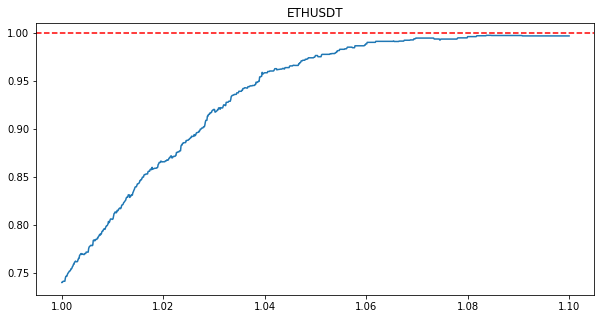

last_index : 34000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.1236 - mean_absolute_error: 0.2411 - val_loss: 0.0224 - val_mean_absolute_error: 0.1195

Epoch 00001: val_loss improved from inf to 0.02243, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_34000.h5
Epoch 2/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0167 - mean_absolute_error: 0.1009 - val_loss: 0.0162 - val_mean_absolute_error: 0.1013

Epoch 00002: val_loss improved from 0.02243 to 0.01618, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_34000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0127 - mean_absolute_error: 0.0880 - val_loss: 0.0135 - val_mean_absolute_error: 0.0922

Epo

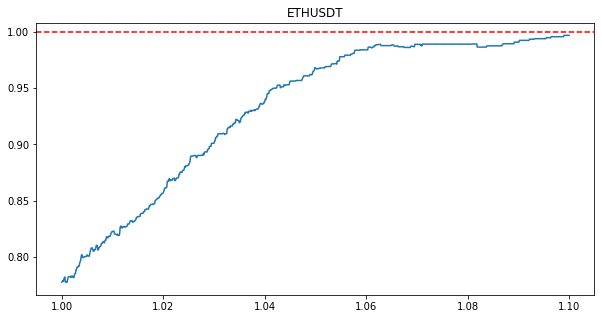

last_index : 35000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0217 - mean_absolute_error: 0.1123 - val_loss: 0.0116 - val_mean_absolute_error: 0.0856

Epoch 00001: val_loss improved from inf to 0.01155, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_35000.h5
Epoch 2/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_absolute_error: 0.0752 - val_loss: 0.0088 - val_mean_absolute_error: 0.0740

Epoch 00002: val_loss improved from 0.01155 to 0.00881, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_35000.h5
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0072 - mean_absolute_error: 0.0652 - val_loss: 0.0078 - val_mean_absolute_error: 0.0690

Epo

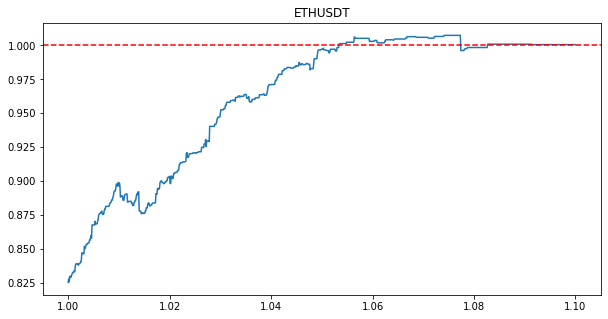

last_index : 36000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0296 - mean_absolute_error: 0.1294 - val_loss: 0.0139 - val_mean_absolute_error: 0.0928

Epoch 00001: val_loss improved from inf to 0.01387, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_36000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_absolute_error: 0.0781 - val_loss: 0.0096 - val_mean_absolute_error: 0.0765

Epoch 00002: val_loss improved from 0.01387 to 0.00955, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_36000.h5
Epoch 3/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0078 - mean_absolute_error: 0.0689 - val_loss: 0.0079 - val_mean_absolute_error: 0.0700

Epoc

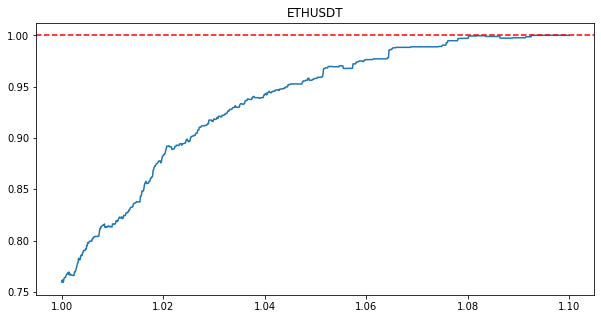

last_index : 37000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.0780 - mean_absolute_error: 0.2018 - val_loss: 0.0191 - val_mean_absolute_error: 0.1082

Epoch 00001: val_loss improved from inf to 0.01908, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_37000.h5
Epoch 2/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0145 - mean_absolute_error: 0.0951 - val_loss: 0.0136 - val_mean_absolute_error: 0.0909

Epoch 00002: val_loss improved from 0.01908 to 0.01361, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_37000.h5
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0115 - mean_absolute_error: 0.0841 - val_loss: 0.0110 - val_mean_absolute_error: 0.0819

Epo

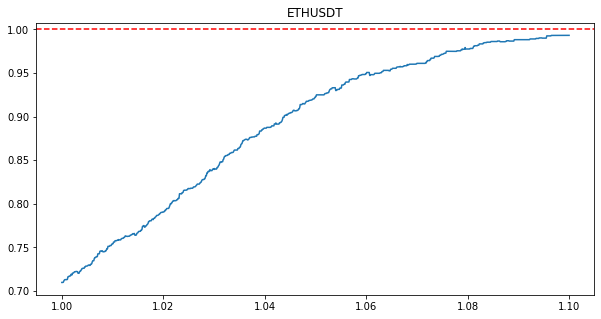

last_index : 38000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 11ms/step - loss: 0.1182 - mean_absolute_error: 0.2371 - val_loss: 0.0221 - val_mean_absolute_error: 0.1180

Epoch 00001: val_loss improved from inf to 0.02209, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_38000.h5
Epoch 2/100
55/55 [==============================] - 1s 9ms/step - loss: 0.0178 - mean_absolute_error: 0.1049 - val_loss: 0.0144 - val_mean_absolute_error: 0.0936

Epoch 00002: val_loss improved from 0.02209 to 0.01441, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_38000.h5
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0128 - mean_absolute_error: 0.0881 - val_loss: 0.0110 - val_mean_absolute_error: 0.0825

Epo

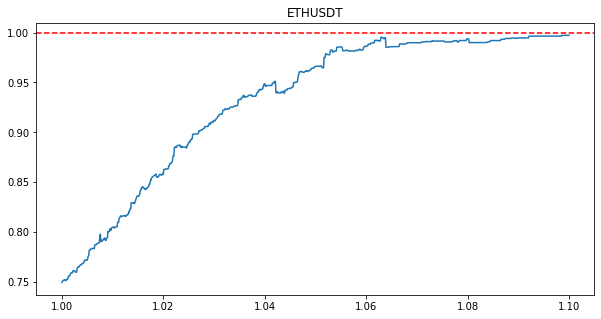

last_index : 39000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

Epoch 1/100
55/55 [==============================] - 1s 11ms/step - loss: 0.0615 - mean_absolute_error: 0.1822 - val_loss: 0.0192 - val_mean_absolute_error: 0.1074

Epoch 00001: val_loss improved from inf to 0.01920, saving model to /content/drive/My Drive/Colab Notebooks/JnQ/ckpt/inner_tick_cnnreg_lscalemm_prefee_gpu_ETHUSDT_15_1_1000_39000.h5
Epoch 2/100
55/55 [==============================] - 0s 9ms/step - loss: 0.0142 - mean_absolute_error: 0.0930 - val_loss: 0.0131 - val_mean_absolute_error: 0.0867


KeyboardInterrupt: ignored

In [10]:
#         1. data slicing      #
tvt_size = 10000
shift_size = int(tvt_size * 0.1)
shift_i = 0

#         2. calc, iteration number     #
# data_len = len(data_x)


while 1:

  # if shift_i == 1:
  #   pass
  # else:
  #   shift_i += 1
  #   continue

  last_index = tvt_size + shift_size * shift_i
  print("last_index :", last_index)
  # print("last_index :", last_index)

  slice_x = data_x[shift_size * shift_i :last_index]
  
  #   reshape to 3d   #
  slice_x = slice_x.reshape(-1, slice_x.shape[1], slice_x.shape[2], 1)

  slice_labels = data_labels[shift_size * shift_i :last_index].reshape(-1, 1)

  if last_index > len(data_x):
    break

  else:
    shift_i += 1


  train_x = slice_x[:int(tvt_size * 0.7)]
  val_x = slice_x[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_x = slice_x[int(tvt_size * 0.9):]

  print("len(train_x) :", len(train_x))
  print("len(val_x) :", len(val_x))
  print("len(test_x) :", len(test_x))

  train_labels = slice_labels[:int(tvt_size * 0.7)]
  val_labels = slice_labels[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_labels = slice_labels[int(tvt_size * 0.9):]

  # sorted_pr = sorted(slice_labels, reverse=True)
  # pct = 0.28
  # len_pct = int(len(slice_labels) * pct)
  # pr_thresh = sorted_pr[len_pct]
  # print("pr_thresh :", pr_thresh)

  # pr_thresh = 1

  # train_y = np.where(train_labels > pr_thresh, 1, 0)
  # val_y = np.where(val_labels > pr_thresh, 1, 0)
  # test_y = np.where(test_labels > pr_thresh, 1, 0)

  train_y = train_labels
  val_y = val_labels
  test_y = test_labels
  
  from tensorflow.keras import utils

  # train_y_ohe = utils.to_categorical(train_y, 2)
  # val_y_ohe = utils.to_categorical(val_y, 2)
  # test_y_ohe = utils.to_categorical(test_y, 2)

  # train_y = train_labels[:, :, [target_label_index]]
  # val_y = val_labels[:, :, [target_label_index]]
  # test_y = test_labels[:, :, [target_label_index]]

  # print("train_labels.shape :", train_labels.shape)
  print("train_x.shape :", train_x.shape)
  print("train_y.shape :", train_y.shape)
  print()

  # from sklearn.utils import class_weight

  # label = train_y.reshape(-1, )
  # class_weights = class_weight.compute_class_weight('balanced', 
  #                                                     classes=np.unique(label),
  #                                                     y=label)
  # class_weights = dict(enumerate(class_weights))
  # print('class_weights :', class_weights)

  from tensorflow.keras.preprocessing.image import ImageDataGenerator 

  datagen = ImageDataGenerator( 
      # rotation_range = 45,
      # zoom_range = 0.5,
      # shear_range = 0.5,
      # horizontal_flip = True,
      # vertical_flip = True,
      # width_shift_range=0.5,
      # height_shift_range=0.5,
      # fill_mode = 'nearest'
      )

  valgen = ImageDataGenerator( 
      )

  datagen.fit(train_x)
  valgen.fit(val_x)
  batch_size = 128

  train_flow = datagen.flow(train_x, train_y, batch_size=batch_size) 
  val_flow = valgen.flow(val_x, val_y, batch_size=batch_size) 
  
  # train_flow = datagen.flow(train_x, train_y_ohe, batch_size=batch_size) 
  # val_flow = valgen.flow(val_x, val_y_ohe, batch_size=batch_size) 



  #         train         #
  pair_name = key.split(".")[0].split(" ")[1]

  # model_name = 'inner_tick_cnn_lscalemm_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, last_index)
  # model_name = 'inner_tick_cnn_lscalemm_postfee_pct_%s_%s_%s_%s_%s.h5' % (pct* 1000, pair_name, input_size, label_size, last_index)
  model_name = 'inner_tick_cnnreg_lscalemm_prefee_gpu_%s_%s_%s_%s_%s.h5' % (pair_name, input_size, label_size, shift_size, last_index)
  # break

  #         train / test      #
  model = cnn2d_model(train_x.shape[1:])
  history = compile_and_fit(model, model_name, train_flow, val_flow)
  # history = compile_and_fit(model, model_name, train_flow, val_flow, class_weight=class_weights)
  
  # break
  model = tf.keras.models.load_model(ckpt_path + model_name)

  test_result = model.predict(test_x)
  print('test_result.shape :', test_result.shape)
  # print('pr_val.shape :', pr_val.shape)

  # y_score = test_result[:, [1]]
  y_score = test_result[:, [0]]
  print('test_y[:5] :', test_y.reshape(-1,)[:5])
  # print('np.unique(test_y) :', np.unique(test_y, return_counts=True))
  print('y_score[:5] :', y_score[:5])
  # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

  print('test_y.shape :', test_y.shape)
  print('y_score.shape :', y_score.shape)

  print('len(test_y) :', len(test_y))

  from sklearn.metrics import precision_recall_curve

  #     precision recall curve   #
  # precision, recall, threshold = precision_recall_curve(test_y, y_score)
  # precision, recall = precision[:-1], recall[:-1]

  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()
  # print(y_pred)


  lvrg = 1
  fee = 0.0006


  # threshold = [0.65]
  # print('threshold :', threshold)
  # break

  acc_pr_bythr = []
  new_thresh = []

  threshold = np.arange(1, 1.1, 0.0001)

  for thresh in threshold:
    
    # if thresh < 0.5:
    #     continue

    y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
    # print('y_pred.shape :', y_pred.shape)
    # print('y_pred :', y_pred)

    #     compare precision     #

    # print('precision :', precision_score(test_y, y_pred))
    # print('recall :', recall_score(test_y, y_pred))
    # print()

    # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
    # print('np.isnan(np.sum(test_y)) :', np.isnan(np.sum(test_y)))

    # # plot_confusion_matrix(best_model, x_test, test_y, normalize=None)
    # # plt.show()  
    # print()

    # from sklearn.metrics import confusion_matrix

    # #     check win-ratio improvement     #
    # cmat = confusion_matrix(test_y, y_pred)
    # # print(cmat)
    # # print(np.sum(cmat, axis=1))
    

    # org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
    # ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
    # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

    test_size = len(test_y)
    test_pr_list = test_labels
    # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

    # print('pr_test.shape :', pr_test.shape)

    # print(y_pred)
    # print(test_pr_list)

    pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1)
    # print("pred_pr_list[:10] :", pred_pr_list[:10])

    #       after fee adjustment    #
    # pred_pr_list = (pred_pr_list - 1 - fee) * lvrg + 1

    # pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
    # pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
    # print('pred_pr_list.shape :', pred_pr_list.shape)

    # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    #   print('thresh :', thresh)
      
    # if len(threshold) == 1:
  #   plt.figure(figsize=(10, 5))
  #   plt.subplot(121)
  #   plt.plot(np.cumprod(test_pr_list))
  #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # # plt.show()

  #   plt.subplot(122)
  #   plt.plot(np.cumprod(pred_pr_list))
  #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
  #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
  #   plt.show()


    acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
    new_thresh.append(thresh)


  print('acc_pr_bythr :', acc_pr_bythr)

  plt.figure(figsize=(10, 5))
  # plt.subplot(121)
  # plt.plot(threshold, precision, label='precision')
  # plt.plot(threshold, recall, label='recall')
  # plt.legend()
  # plt.title('precision recall')
  # plt.show()

  # plt.subplot(122)
  plt.plot(new_thresh, acc_pr_bythr)
  plt.axhline(1, linestyle='--', color='r')
  plt.title(pair_name)
  plt.show()



#### get_best_thr function

In [ ]:
def get_best_thr(thresh_list, test_x, pred_y, lvrg=5, plotting=False, pr_plot=False):
  
  thresh_pr_list = []
  fee = 0.0006

   
  # # plotting = True
  # plotting = False

  # # pr_plot = True
  # pr_plot = False

  #       find best thresh        #
  for thresh in tqdm(thresh_list):

    pr_list = []
    i = 0
    while 1:
    # for i in range(len(test_y)):

      try:
        input = test_x[i, :, target_label_index]
      except:
        input = test_x[i, :, 0]


      label = test_y[i]
      pred = pred_y[i]

      # print("label.shape :", label.shape)
      # print("len(label) :", len(label))
      # print("shift_size :", shift_size)
      # break

      # input_close = test_slice_close_x[i, :, :]
      # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
      # close = test_slice_label_close_x[i, :, :]

      #     find highest / lowest arg     #
      # high_arg = np.argmax(pred)
      # low_arg = np.argmin(pred)

      #     we always sell high, buy low    #
      label_pr = label[-1]
      pred_pr = pred[-1]

      if plotting:

        # if pred_pr > thresh:

          # plt.subplot(211)
          # plt.plot(np.arange(len(input_close)), input_close)
          # plt.plot(np.arange(len(close)) + input_size, close)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)

          # plt.subplot(212)
          # plt.plot(np.arange(len(input)), input,
          #         label='Inputs', marker='.', zorder=-10)    
          # plt.scatter(np.arange(len(label)), label,
          #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
          # plt.scatter(np.arange(len(pred)), pred,
          #             marker='X', edgecolors='k', label='Predictions',
          #             c='#ff7f0e', s=64)

          plt.plot(label)
          plt.plot(pred)
          
          plt.axhline(thresh)
          # plt.plot(pred)
          # plt.plot(label)
          # plt.axvline(high_arg + input_size)
          # plt.axvline(low_arg + input_size)


          # plt.suptitle("%.3f" % pr)
          plt.show()

      calc_label_pr = (label_pr - fee) * lvrg + 1
      calc_pred_pr = (pred_pr - fee) * lvrg + 1

      if calc_pred_pr > thresh + 1:
        pr_list.append(calc_label_pr)
        # print("label_pr :", label_pr)

      #     i should moved to end of trading index    #
      #     long    #
      # if high_arg > low_arg:
      #   i += high_arg
      # else:
      #   i += low_arg

      i += 1

      # print("i :", i)

      if i >= len(test_y):
        break
      # else:
      #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

      #     shift, if trade complished    #

    if pr_plot:
      np_pr_list = np.array(pr_list)
      wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

      plt.plot(np.cumprod(pr_list))
      plt.title("%s\nwr : %.3f" % (key, wr))
      plt.show()

    if len(pr_list) == 0:
      thresh_pr_list.append(1)
    else:
      thresh_pr_list.append(np.cumprod(pr_list)[-1])

  best_thr = thresh_list[np.argmax(thresh_pr_list)]

  if len(thresh_list) != 1:
    plt.plot(thresh_list, thresh_pr_list)
    plt.axvline(best_thr)
    plt.title(best_thr)
    plt.show()

  return best_thr

#### find best_thr

Text(0.5, 1.0, '0.013460000000000034')

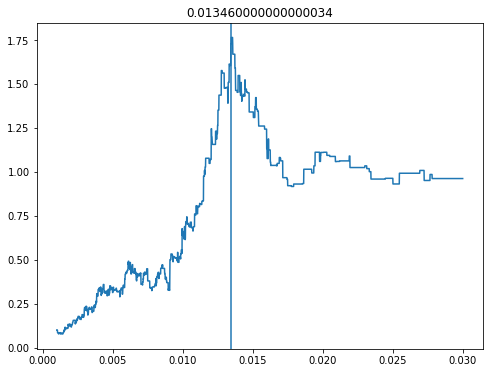

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
test_result = model.predict(test_x)

pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []

# plotting = True
plotting = False

# pr_plot = True
pr_plot = False

thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.001, 0.03, 1e-5)


#       find best thresh        #
for thresh in tqdm(thresh_list):

  pr_list = []
  i = 0
  while 1:
  # for i in range(len(test_y)):

    try:
      input = test_x[i, :, target_label_index]
    except:
      input = test_x[i, :, 0]


    label = test_y[i]
    pred = pred_y[i]

    # print("label.shape :", label.shape)
    # print("len(label) :", len(label))
    # print("shift_size :", shift_size)
    # break

    # input_close = test_slice_close_x[i, :, :]
    # # input_close = test_x[i, :, 3] * train_std['close'] + train_mean['close']
    # close = test_slice_label_close_x[i, :, :]

    #     find highest / lowest arg     #
    # high_arg = np.argmax(pred)
    # low_arg = np.argmin(pred)

    #     we always sell high, buy low    #
    label_pr = label[-1]
    pred_pr = pred[-1]

    if plotting:

      # if pred_pr > thresh:

        # plt.subplot(211)
        # plt.plot(np.arange(len(input_close)), input_close)
        # plt.plot(np.arange(len(close)) + input_size, close)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)

        # plt.subplot(212)
        # plt.plot(np.arange(len(input)), input,
        #         label='Inputs', marker='.', zorder=-10)    
        # plt.scatter(np.arange(len(label)), label,
        #           edgecolors='k', label='Labels', c='#2ca02c', s=64)
        # plt.scatter(np.arange(len(pred)), pred,
        #             marker='X', edgecolors='k', label='Predictions',
        #             c='#ff7f0e', s=64)

        plt.plot(label)
        plt.plot(pred)
        
        plt.axhline(thresh)
        # plt.plot(pred)
        # plt.plot(label)
        # plt.axvline(high_arg + input_size)
        # plt.axvline(low_arg + input_size)


        # plt.suptitle("%.3f" % pr)
        plt.show()

    calc_label_pr = (label_pr - fee) * lvrg + 1
    calc_pred_pr = (pred_pr - fee) * lvrg + 1

    if calc_pred_pr > thresh + 1:
      pr_list.append(calc_label_pr)
      # print("label_pr :", label_pr)

    #     i should moved to end of trading index    #
    #     long    #
    # if high_arg > low_arg:
    #   i += high_arg
    # else:
    #   i += low_arg

    i += 1

    # print("i :", i)

    if i >= len(test_y):
      break
    # else:
    #   pr = (close[low_arg] / close[high_arg] - 1 - fee) * lvrg + 1

    #     shift, if trade complished    #

  if pr_plot:
    np_pr_list = np.array(pr_list)
    wr = len(np_pr_list[np_pr_list > 1]) / len(np_pr_list[np_pr_list != 1]) 

    plt.plot(np.cumprod(pr_list))
    plt.title("%s\nwr : %.3f" % (key, wr))
    plt.show()

  thresh_pr_list.append(np.cumprod(pr_list)[-1])

best_thr = thresh_list[np.argmax(thresh_pr_list)]
plt.plot(thresh_list, thresh_pr_list)
plt.axvline(best_thr)
plt.title(best_thr)

#### val_thr on test_set

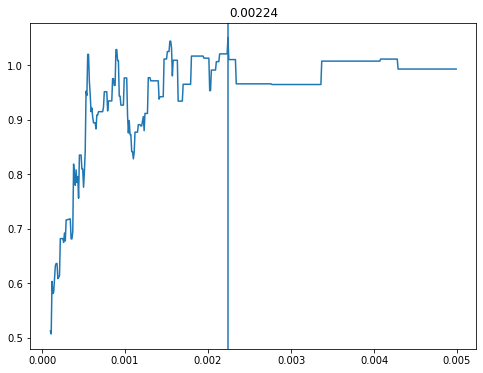

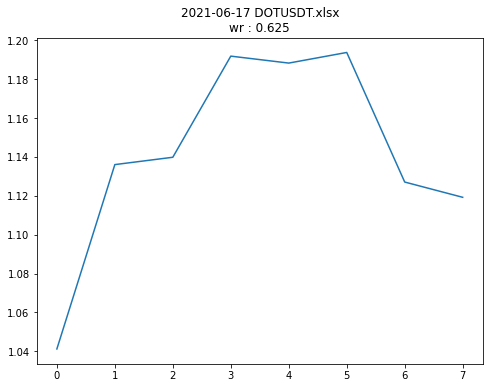

0.00224

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
val_result = model.predict(val_x)
test_result = model.predict(test_x)

# pred_y = test_result
# pred_y = test_result[:, :, target_label_index]

fee = 0.0006
lvrg = 5
# lvrg = 1
thresh_pr_list = []


# thresh = 0.015
# thresh = -0.001

thresh_list = np.arange(0.0001, 0.005, 1e-5)

val_best_thr = get_best_thr(thresh_list, val_x, val_result)

get_best_thr([val_best_thr], test_x, test_result, pr_plot=True)


#### train_thresh

In [ ]:

model = tf.keras.models.load_model(ckpt_path + model_name)
train_result = model.predict(train_x)
train_best_thr = get_best_thr(thresh_list, train_x, train_result)
